In [1]:
%pylab inline
import pandas as pd
import numpy as np
import tqdm
import glob
import os.path
import openslide
import cv2
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [2]:
dpath = './data/' # "/DATA/GDC/lana/"

In [3]:
slide_files = { os.path.basename(fn).upper(): fn for fn in glob.glob(dpath + "*/*.svs") }

In [4]:
slides = pd.read_csv('./slides.csv')

In [5]:
all_normal = slides.loc[slides.percent_normal_cells == 100]
all_tumor = slides.loc[slides.percent_tumor_cells]

In [6]:
#y = slides.days_to_death.fillna(slides.days_to_last_follow_up)
slides = slides.loc[slides.days_to_death.notnull()]
y = slides.days_to_death.dropna()


In [7]:
y.describe()

count     204.000000
mean      776.377451
std       754.237167
min         9.000000
25%       223.000000
50%       557.000000
75%      1135.000000
max      3258.000000
Name: days_to_death, dtype: float64

In [8]:
die_early = slides.loc[y < 180]
die_late = slides.loc[y>1500]

In [9]:
def pull_samples(slide_fn, level):
    slide = openslide.open_slide(slide_fn)
    
    keep = []
    empty = []
    bad = []
    tiles = []

    min_empty=0.0
    max_empty=0.50
    min_std=2.
    slide_dim = slide.level_dimensions[level]
    slide_dim_0 = slide.level_dimensions[0]


    slide_width, slide_height = slide_dim
    slide_width_0, slide_height_0 = slide_dim_0

    tile_rgba = np.array(slide.read_region((0,0),level,slide_dim))
    gray = cv2.cvtColor(tile_rgba,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    #plt.imshow(tile_rgba)
    len(range(0, slide_height, 256)), len(range(0, slide_width, 256))

    pct_e = []
    for row in tqdm.tnrange(0, slide_height, 256):
        for col in range(0, slide_width, 256):
            tile_width = min(256, slide_width - col)
            tile_height = min(256, slide_height - row)

            tile_loc_0 = ( col * slide_width_0 // slide_width, row * slide_height_0 // slide_height  )
            tile = slide.read_region(tile_loc_0, level, (tile_width, tile_height))

            thresh_area = thresh[row:(row+tile_height), col:(col+tile_width)]
            area_sum = (thresh_area > -1).sum()
            if area_sum == 0:
                bad.append(tile)
            else:
                pct_empty = (thresh_area == 0).sum()/area_sum
                pct_e.append(pct_empty)
                #print(pct_empty, tile_loc_0, level, tile_width, tile_height)
                #plt.imshow(tile)
                #plt.show()
                if pct_empty < max_empty: # and pct_empty > min_empty and  gray.std()>min_std:
                    keep.append(tile)
                else:
                    empty.append(tile)

    slide.close()
    return keep, empty

In [ ]:
def plot_slides(slide_array):
    thumb_size = (50,25)
    num_slides = 9
    slide_sample_idx = random.choice(range(len(slide_array)), size=num_slides)
    plt.figure(figsize=thumb_size)
    columns = 5
    for i, slide_idx in tqdm.tqdm_notebook(enumerate(slide_sample_idx), total=num_slides):
        plt.subplot(num_slides / columns + 1, columns, i + 1)
        plt.imshow(slide_array[slide_idx])

In [10]:
def tile_slides(slide_array):
    '''
    Create single 3x3 slide of each subsample
    
    '''
    out_side_length = 3
    num_slides = out_side_length**2

    
    (img_height,img_width) = slide_array[0].size #first image H x W
    total_width  = out_side_length * img_width
    total_height = out_side_length * img_height
    new_im = Image.new('RGB', (total_width, total_height))
    
    slide_sample_idx = random.choice(range(len(slide_array)), size=num_slides)

    x_offset,y_offset = (0,0)
    for i, slide_idx in tqdm.tqdm_notebook(enumerate(slide_sample_idx), total=num_slides):

        new_im.paste(slide_array[slide_idx],(x_offset,y_offset))
        x_offset =(x_offset + img_width) % total_width
        if ((i+1) % out_side_length) == 0:
            y_offset += img_height
    plt.imshow(new_im)
    

In [11]:
def plots_from_samples(tumor_slides):
    rand_tumor_fn = tumor_slides[random.choice(range(len(tumor_slides)))].upper()
    print(rand_tumor_fn)
    keep, empty = pull_samples(slide_files[rand_tumor_fn], 1)
    #plot_slides(keep)
    tile_slides(keep)

TCGA-CC-A8HT-01A-01-TSA.06673649-CD04-434F-A381-0C33D56450EA.SVS


HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

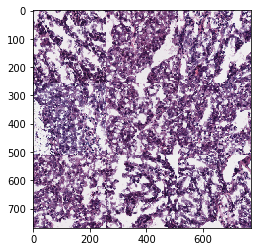

In [12]:
plots_from_samples(list(die_early.slide_file_name))

TCGA-DD-A11D-01A-01-BSA.F198D900-5D22-4BC5-A29B-226106AF5399.SVS


HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

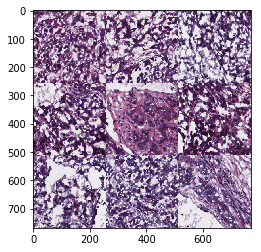

In [13]:
plots_from_samples(list(die_late.slide_file_name))